# Demo for Connectivity Optimization with Undirected Graph

## 1 Experimental Setup

Predefined graph: 6-nodes, sparse connection with edge weights 0.6

Data generalization according to GRMF: given $\mathbf{y}|\mathbf{x},\mathbf{L}\sim \mathcal{N}(\mathbf{x},\sigma^2\mathbf{I}), \mathbf{x}|\mathbf{L}\sim\mathcal{N}(\mathbf{0},\mathbf{L}^\dagger)$, generate $\mathbf{y}|\mathbf{L}\sim\mathcal{N}(\mathbf{0},\sigma^2\mathbf{I}+\mathbf{L}^\dagger)$

Data number in total: 128

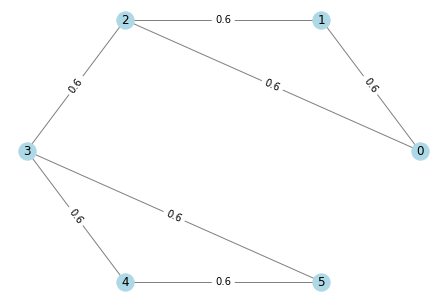

tensor(5.0400)
[[ 1.2       -0.6       -0.6       -0.        -0.        -0.       ]
 [-0.6        1.2       -0.6       -0.        -0.        -0.       ]
 [-0.6       -0.6        1.8000001 -0.6       -0.        -0.       ]
 [-0.        -0.        -0.6        1.8000001 -0.6       -0.6      ]
 [-0.        -0.        -0.        -0.6        1.2       -0.6      ]
 [-0.        -0.        -0.        -0.6       -0.6        1.2      ]]


In [ ]:
# Graph design
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.sparse as sp
from scipy.sparse.csgraph import laplacian
import networkx as nx
import matplotlib.pyplot as plt

torch.manual_seed(42)
torch.random.manual_seed(42)

def draw_graph_from_adj(adj, title=None):
    G = nx.from_numpy_array(adj.numpy())
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
    edge_labels = {(u, v): f'{d["weight"]:.1f}' for (u, v, d) in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    if title is not None:
        plt.title(title)
    plt.show()

def generate_graph_from_edges(num_nodes, edges, weights=None):
    if weights is None:
        weights = torch.ones(len(edges))
    adj = torch.zeros((num_nodes, num_nodes))
    adj[edges[:, 0], edges[:, 1]] = weights
    adj = adj + adj.t()  # make it symmetric
    adj.fill_diagonal_(0)  # remove self-loops
    
    # For visualization only (using scipy sparse)
    draw_graph_from_adj(adj)
    
    return adj

def generate_y(num_nodes, sigma, L, n):
    # Convert L to tensor if it's not already
    L = torch.tensor(L, dtype=torch.float32)
    
    cov = sigma**2 * torch.eye(num_nodes) + torch.pinverse(L)
    # For generating multivariate normal, we need to make sure covariance is symmetric
    cov = (cov + cov.t()) / 2
    
    # Generate multivariate normal samples
    y = torch.distributions.MultivariateNormal(
        loc=torch.zeros(num_nodes),
        covariance_matrix=cov
    ).sample((n,))
    
    return y

edges = [[0,1],[0,2],[1,2],[2,3],[3,4],[4,5],[3,5]]
edges = torch.tensor(edges)
weights = torch.tensor([0.6]*len(edges))
num_nodes = 6
adj = generate_graph_from_edges(num_nodes, edges, weights)
print(adj.norm()**2)
L = laplacian(adj, normed=False)
print(L)
# generate data
sigma = 0.1
mu = sigma ** 2
n = 128
y = generate_y(num_nodes, sigma, L, n)

## 2 Graph Learning Module (Simple)

- Define a *learnable* embedding for each node, the embedded signals $\tilde{\mathbf{x}}_i = [x_i;\mathbf{e}_i]$
- Feature extraction: A single linear layer with activation `LeakyReLU(0.2)`: $\mathbf{f}_i = \sigma(\mathbf{H}\tilde{\mathbf{x}}_i+\mathbf{h})$
- Weight calculation: $w_{i,j}=\alpha\exp(-\Vert \mathbf{f}_i - \mathbf{f}_j \Vert_2^2)$
- Laplacian matrix: $\mathbf{L}=\text{diag}(\mathbf{W1})-\mathbf{W}$

Parameters: $\Theta=(\{\mathbf{e}_i\}_{i=1}^{N}, \mathbf{H},\mathbf{h})$

In [2]:
class GraphLearningModule(nn.Module):
    # generate weight matrix from node embeddings
    def __init__(self, num_nodes, emb_dim=6, feature_dim=3, c=8):
        super(GraphLearningModule, self).__init__()
        self.num_nodes = num_nodes
        self.emb_dim = emb_dim
        self.feature_dim = feature_dim

        # embedding vectors
        self.node_embeddings = nn.Parameter(torch.randn(num_nodes, emb_dim))  
        self.fc = nn.Linear(emb_dim, feature_dim)
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.c = c

    def forward(self, x, params=None):
        """
        x: (B, N)
        params: dict[str, tensor] (可选，用于 MAML/unrolled optimization)
        """
        if params is None:
            node_embeddings = self.node_embeddings
            fc_weight = self.fc.weight
            fc_bias = self.fc.bias
        else:
            node_embeddings = params["node_embeddings"]
            fc_weight = params["fc.weight"]
            fc_bias = params["fc.bias"]

        B = x.size(0)

        # 1. embed each node
        e = x.unsqueeze(-1) + node_embeddings.unsqueeze(0)  # (B, N, emb_dim)

        # 2. linear + activation
        f = F.linear(e, fc_weight, fc_bias)   # (B, N, feature_dim)
        f = self.leakyrelu(f)

        # 3. pairwise difference
        df = f.unsqueeze(2) - f.unsqueeze(1)  # (B, N, N, feature_dim)

        # 4. adjacency by RBF kernel
        adj = torch.exp(-(df ** 2).sum(-1)).mean(0)  # (N, N)
        adj.fill_diagonal_(0)

        return adj

## 3 GEM Algorithm
### 3.1 Hard E-step: Update $\mathbf{x}$
$$
\min_x \Vert \mathbf{y}-\mathbf{x}\Vert_2^2 + \mu \mathbf{x}^\top\mathbf{Lx}\\
\mathbf{x}^*=(\mathbf{I}+\mu\mathbf{L})^{-1}\mathbf{y}
$$
In practice, solve in CG

Update graph with new $\mathbf{x}$ and project it to the sphere
### 3.2 M-step-1: update graph weights $\Theta$
$$
\min_\Theta \mathbf{x}^\top\mathbf{Lx} \quad \text{s.t. }~ \Vert \mathbf{W}\circ\mathbf{S} \Vert_2^2=c
$$
Projected Gradient Method:
1. Gradient step: $\Theta^{t+1} = \Theta^{t} - \delta^{t}\nabla_\Theta(\mathbf{x}^\top\mathbf{L^tx})$
2. Recompute graph: $\mathbf{W}^{t+1} = \mathbf{W}(\Theta^{t+1})$
3. Project to the sphere: $\alpha \leftarrow \frac{\sqrt{c}}{\Vert \mathbf{W}^{t+1} \Vert_F} \alpha$
### 3.3 M-step-2 update graph connectivity $\mathbf{S}$
$$
\min_{\mathbf{S}\in\{0,1\}^{N\times N}} \mathbf{x}^\top\mathbf{Lx} - \log|\mathbf{L}|+ \gamma \Vert \mathbf{S}\Vert_{0,\text{off}}
$$
**Method A (Proximal Gradient Descent)**
 Define $\mathbf{R}=(\mathbf{J}+\mathcal{L}(\mathbf{A}))^{-1}, \mathbf{r}=\text{diag}(\mathbf{R}), \tilde{\mathbf{R}}=\mathbf{R}-\frac{1}{2}(\mathbf{r1}^\top+\mathbf{1r}^\top)$
1. Update $\mathbf{A}$
$$
\mathbf{A}\leftarrow \Pi_{[0,1]^{n\times n}}\circ \text{Soft}_{\eta^{(t)}\gamma}\left(\mathbf{A}-\eta^{(t)} \mathbf{W}^o \circ (\tilde{\mathbf{R}} - \tilde{\mathbf{S}})\right)
$$
2. Update $\tilde{\mathbf{R}}$
$$
\mathbf{W} \leftarrow \mathbf{A}\circ \mathbf{W}^o,\quad \mathbf{L}\leftarrow \text{diag}(\mathbf{W}\mathbf{1}) -  \mathbf{W}\\
\mathbf{R}\leftarrow (\mathbf{J}+\mathbf{L})^{-1},\quad \tilde{\mathbf{R}}=\mathbf{R}-\frac{1}{2}(\mathbf{r1}^\top+\mathbf{1r}^\top)
$$
**Method B (Block Coordinate PGD)** Update one edge at a time
1. Update $\mathbf{A}$ at edge $(i,j)$
$$
A_{ij} \leftarrow \Pi_{[0,1]}\circ \text{Soft}_{\eta \gamma}\left(A_{ij} - \eta W^o_{ij}(\tilde{R}_{ij}-\tilde{S}_{ij})\right)
$$
2. Update $\tilde{\mathbf{R}}$
$$
\mathbf{Q} = (\tilde{\mathbf{r}}_i - \tilde{\mathbf{r}}_j)(\tilde{\mathbf{r}}_i - \tilde{\mathbf{r}}_j)^\top\\
\tilde{\mathbf{M}} = \tilde{\mathbf{Q}} - \frac{1}{2} (\mathbf{q1}^\top +\mathbf{1q}^\top)\\
\tilde{\mathbf{R}}\leftarrow \tilde{\mathbf{R}} + \frac{\Delta A_{ij}}{1-2\Delta A_{ij}\tilde{R}_{ij}}\tilde{\mathbf{M}}
$$

In [3]:
import math
def Laplacian_from_adj(adj):
    D = torch.diag(adj.sum(1))
    L = D - adj
    return L

def GLR(x, L):
    # x in shape (B, N), L in shape (N, N)
    return torch.trace(x @ L @ x.t()) / x.size(0) # scalar, mean of GLR over batch

class GEM(nn.Module):
    def __init__(self, num_nodes, mu, gamma, step_size, emb_dim=6, feature_dim=3, c=8, scale=True):
        super(GEM, self).__init__()
        self.glm = GraphLearningModule(num_nodes, emb_dim, feature_dim, c)
        # self.S = torch.ones((num_nodes, num_nodes)) - torch.eye(num_nodes)  # all-one matrix with zero diagonal
        self.mu = mu
        self.c = c
        self.step_size = step_size
        self.gamma = gamma
        self.scale = scale
    
    def scale_W(self, adj, S):
        W = adj * S
        scale_factor = 1
        if self.scale:
            scale_factor = math.sqrt(self.c) / W.norm() if W.norm() != 0 else 1
            W = W * scale_factor
        return W, scale_factor

    def E_step(self, y, W):
        # y in (B, N)
        B = y.size(0)
        D = torch.diag(W.sum(1))
        L = D - W
        cov = torch.eye(self.glm.num_nodes) + self.mu * L
        return torch.linalg.solve(cov, y.t()).t()  # return in shape (B, N)
    
    def M_step_1(self, x, L):
        loss = GLR(x, L)
        # backward to gradient descent
        grads = torch.autograd.grad(loss, self.glm.parameters(), create_graph=True)
        new_params = {}
        for (name, param), grad in zip(self.glm.named_parameters(), grads):
            new_params[name] = param - self.step_size * grad
        return new_params

    def tilde_operation(self, Sigma):
        N = Sigma.size(0)
        diag_Sigma = torch.diag(Sigma)
        tilde_Sigma = Sigma - (diag_Sigma.unsqueeze(0) + diag_Sigma.unsqueeze(1)) / 2
        return tilde_Sigma
    
    def soft_thresholding(self, W, tau):
        return torch.sign(W) * torch.clamp(torch.abs(W) - tau, min=0.0)

    def M_step_2(self, x, W0, S_init=None, num_iters=10, block_coordinate=False):
        # for fixed x, Sigma is fixed
        N = self.glm.num_nodes
        if S_init is None:
            S_init = torch.ones((N, N), device=x.device) - torch.eye(N, device=x.device)  # all-one matrix with zero diagonal
        S = S_init
        Sigma = x.T @ x / x.shape[0] # (N, N)
        tilde_Sigma = self.tilde_operation(Sigma)

        J = torch.ones((N, N), device=x.device) / N
        H = torch.ones((N, N), device=x.device) - torch.eye(N, device=x.device)

        # pre-define the first tilde_R
        W = W0 * S
        L = torch.diag(W.sum(1)) - W
        R = torch.inverse(J + L)
        tilde_R = self.tilde_operation(R)

        if block_coordinate:

            for iter in range(num_iters):
                for i in range(N):
                    for j in range(i + 1, N): # iterate over all upper triangular entries
                        # PGD
                        # tilde_R_old = tilde_R_old.clone()
                        S_new_ij = S[i, j] - self.step_size * (W0[i, j] * (tilde_R[i, j] - tilde_Sigma[i, j]))
                        S_new_ij = self.soft_thresholding(S_new_ij, tau=self.step_size * self.gamma)
                        S_new_ij = torch.clamp(S_new_ij, min=0.0, max=1.0)
                        print(f'BCGD iter {iter+1}/{num_iters}, updating S[{i},{j}]: {S[i, j]:.4f} -> {S_new_ij:.4f}')
                        delta_S_ij = S_new_ij - S[i, j]
                        S[i, j] = S_new_ij
                        S[j, i] = S_new_ij  # symmetric update

                        # update tilde_R after each row update
                        delta_r = (tilde_R[i] - tilde_R[j])
                        Q = self.tilde_operation(delta_r.unsqueeze(1) @ delta_r.unsqueeze(0))  # (N, N)
                        tilde_R = tilde_R + delta_S_ij / (1 - 2 * delta_S_ij) * Q
        else:
            for i in range(num_iters):
                # update full tilde_R
                # PGD
                S_new = S - self.step_size * (W0 * (tilde_R - tilde_Sigma)) 
                S_new = self.soft_thresholding(S_new, tau=self.step_size * self.gamma)
                S_new = torch.clamp(S_new, min=0.0, max=1.0)
                S_new.fill_diagonal_(0)
                if i % 10 == 0:
                    print(f'PGD iter {i+1}/{num_iters}, ||S_new - S||_F = {torch.norm(S_new - S):.4f}')
                # update tilde_R
                S = S_new
                W = W0 * S  # initialize W
                L = torch.diag(W.sum(1)) - W
                R = torch.inverse(J + L)
                tilde_R = self.tilde_operation(R)

        return S

    def single_step(self, y, adj, S, params=None):
        # y in (B, N)
        B = y.size(0)
        W0, _ = self.scale_W(adj, S)

        # E-step
        x = self.E_step(y, W0)
        # recompute graph
        adj1 = self.glm(x, params=params) # unregularized adjacency
        W1, _ = self.scale_W(adj1, S)  # element-wise product to enforce sparsity pattern
        L1 = torch.diag(W1.sum(1)) - W1
        print(f'after E-step: delta_W norm {torch.norm(W1 - W0):.4f}, GLR {GLR(x, L1):.4f}, adj norm^2 {adj1.norm()**2:.4f}')

        # M-step-1: minimize GLR
        new_params = self.M_step_1(x, L1) # update parameters in glm
        adj2 = self.glm(x, params=new_params) # unregularized adjacency
        W2, alpha2 = self.scale_W(adj2, S)  # element-wise product to enforce sparsity pattern
        L2 = torch.diag(W2.sum(1)) - W2
        print(f'after M-step-1: delta_W norm {torch.norm(W2 - W1):.4f}, GLR {GLR(x, L2):.4f}, adj norm^2 {adj2.norm()**2:.4f}')

        # M-step-2: optimizing alpha with gradient steps
        S1 = self.M_step_2(x, adj2 * alpha2, num_iters=100, block_coordinate=False)
        print(S1)
        return x, adj2 * alpha2, S1, params
    
    def forward(self, y, S_init, num_iters=10, adj_init=None, params=None):
        adj = self.glm(y) if adj_init is None else adj_init
        S = S_init
        _, alpha = self.scale_W(adj, S)
        adj = adj * alpha  # scale initial adjacency
        
        for it in range(num_iters):
            print(f'Iteration {it+1}/{num_iters}')
            x, adj, S, params = self.single_step(y, adj, S, params=params)
            W = adj * S
            print('W norm^2 at Iteration', it+1, W.norm()**2)
            draw_graph_from_adj(W.detach().cpu(), title=f'Learned Graph at Iteration {it+1}')
        return x, adj, S

Iteration 1/5
after E-step: delta_W norm 0.0075, GLR 12.9142, adj norm^2 5.5283
after M-step-1: delta_W norm 0.2542, GLR 12.1727, adj norm^2 4.7794
PGD iter 1/100, ||S_new - S||_F = 0.0372
PGD iter 11/100, ||S_new - S||_F = 0.0365
PGD iter 21/100, ||S_new - S||_F = 0.0358
PGD iter 31/100, ||S_new - S||_F = 0.0350
PGD iter 41/100, ||S_new - S||_F = 0.0340
PGD iter 51/100, ||S_new - S||_F = 0.0329
PGD iter 61/100, ||S_new - S||_F = 0.0315
PGD iter 71/100, ||S_new - S||_F = 0.0300
PGD iter 81/100, ||S_new - S||_F = 0.0281
PGD iter 91/100, ||S_new - S||_F = 0.0258
tensor([[0.0000, 0.4710, 0.5480, 0.5732, 0.4470, 0.4772],
        [0.4710, 0.0000, 0.5698, 0.5941, 0.1639, 0.3407],
        [0.5480, 0.5698, 0.0000, 0.0919, 0.2642, 0.2175],
        [0.5732, 0.5941, 0.0919, 0.0000, 0.8765, 0.6327],
        [0.4470, 0.1639, 0.2642, 0.8765, 0.0000, 0.4788],
        [0.4772, 0.3407, 0.2175, 0.6327, 0.4788, 0.0000]],
       grad_fn=<CopySlices>)
W norm^2 at Iteration 1 tensor(1.2383, grad_fn=<PowBack

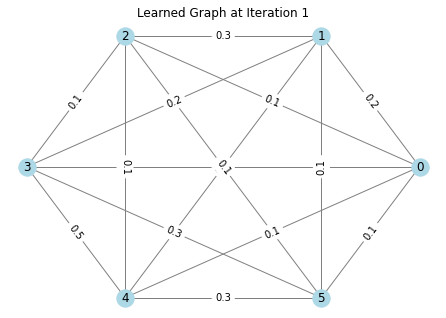

Iteration 2/5
after E-step: delta_W norm 0.2502, GLR 10.6779, adj norm^2 5.4962
after M-step-1: delta_W norm 0.2415, GLR 9.5985, adj norm^2 4.6549
PGD iter 1/100, ||S_new - S||_F = 0.0572
PGD iter 11/100, ||S_new - S||_F = 0.0562
PGD iter 21/100, ||S_new - S||_F = 0.0550
PGD iter 31/100, ||S_new - S||_F = 0.0535
PGD iter 41/100, ||S_new - S||_F = 0.0514
PGD iter 51/100, ||S_new - S||_F = 0.0486
PGD iter 61/100, ||S_new - S||_F = 0.0403
PGD iter 71/100, ||S_new - S||_F = 0.0366
PGD iter 81/100, ||S_new - S||_F = 0.0315
PGD iter 91/100, ||S_new - S||_F = 0.0240
tensor([[0.0000, 0.3199, 0.4490, 0.3374, -0.0000, 0.3315],
        [0.3199, 0.0000, 0.5347, 0.0401, 0.0000, -0.0000],
        [0.4490, 0.5347, 0.0000, 0.4603, -0.0000, 0.0000],
        [0.3374, 0.0401, 0.4603, 0.0000, 0.4486, 0.4684],
        [-0.0000, 0.0000, -0.0000, 0.4486, 0.0000, 0.4420],
        [0.3315, -0.0000, 0.0000, 0.4684, 0.4420, 0.0000]],
       grad_fn=<CopySlices>)
W norm^2 at Iteration 2 tensor(2.8024, grad_fn=<Po

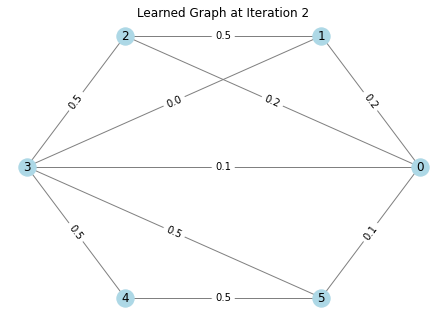

Iteration 3/5
after E-step: delta_W norm 0.1977, GLR 7.7865, adj norm^2 5.4760
after M-step-1: delta_W norm 0.0782, GLR 8.7227, adj norm^2 5.1826
PGD iter 1/100, ||S_new - S||_F = 0.0861
PGD iter 11/100, ||S_new - S||_F = 0.0844
PGD iter 21/100, ||S_new - S||_F = 0.0821
PGD iter 31/100, ||S_new - S||_F = 0.0784
PGD iter 41/100, ||S_new - S||_F = 0.0646
PGD iter 51/100, ||S_new - S||_F = 0.0569
PGD iter 61/100, ||S_new - S||_F = 0.0430
PGD iter 71/100, ||S_new - S||_F = 0.0261
PGD iter 81/100, ||S_new - S||_F = 0.0172
PGD iter 91/100, ||S_new - S||_F = 0.0110
tensor([[0.0000, 0.1281, 0.2641, 0.1036, 0.0000, 0.1007],
        [0.1281, 0.0000, 0.1595, 0.1395, 0.0214, 0.0000],
        [0.2641, 0.1595, 0.0000, 0.1807, 0.1065, -0.0000],
        [0.1036, 0.1395, 0.1807, 0.0000, 0.2472, 0.0012],
        [0.0000, 0.0214, 0.1065, 0.2472, 0.0000, 0.4425],
        [0.1007, 0.0000, -0.0000, 0.0012, 0.4425, 0.0000]],
       grad_fn=<CopySlices>)
W norm^2 at Iteration 3 tensor(1.6619, grad_fn=<PowBack

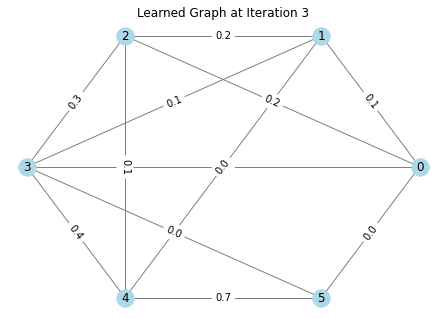

Iteration 4/5
after E-step: delta_W norm 0.0657, GLR 7.1244, adj norm^2 5.4815
after M-step-1: delta_W norm 0.2120, GLR 8.3031, adj norm^2 6.2891
PGD iter 1/100, ||S_new - S||_F = 0.1612
PGD iter 11/100, ||S_new - S||_F = 0.1577
PGD iter 21/100, ||S_new - S||_F = 0.1490
PGD iter 31/100, ||S_new - S||_F = 0.0889
PGD iter 41/100, ||S_new - S||_F = 0.0369
PGD iter 51/100, ||S_new - S||_F = 0.0219
PGD iter 61/100, ||S_new - S||_F = 0.0163
PGD iter 71/100, ||S_new - S||_F = 0.0118
PGD iter 81/100, ||S_new - S||_F = 0.0079
PGD iter 91/100, ||S_new - S||_F = 0.0050
tensor([[0.0000, 0.0797, 0.0880, 0.0418, 0.0000, 0.0000],
        [0.0797, 0.0000, 0.0781, -0.0000, 0.0000, 0.0958],
        [0.0880, 0.0781, 0.0000, 0.0220, 0.1295, 0.0000],
        [0.0418, -0.0000, 0.0220, 0.0000, 0.2008, 0.2682],
        [0.0000, 0.0000, 0.1295, 0.2008, 0.0000, 0.1714],
        [0.0000, 0.0958, 0.0000, 0.2682, 0.1714, 0.0000]],
       grad_fn=<CopySlices>)
W norm^2 at Iteration 4 tensor(1.8387, grad_fn=<PowBack

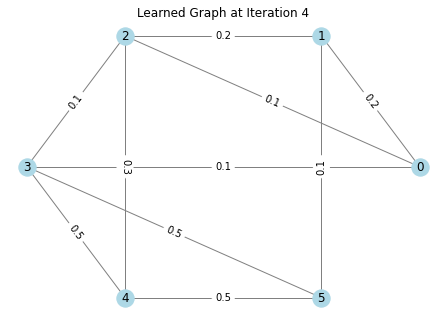

Iteration 5/5
after E-step: delta_W norm 0.1583, GLR 6.7032, adj norm^2 5.4809
after M-step-1: delta_W norm 0.1214, GLR 6.2720, adj norm^2 6.1223
PGD iter 1/100, ||S_new - S||_F = 0.2538
PGD iter 11/100, ||S_new - S||_F = 0.2464
PGD iter 21/100, ||S_new - S||_F = 0.1338
PGD iter 31/100, ||S_new - S||_F = 0.0322
PGD iter 41/100, ||S_new - S||_F = 0.0106
PGD iter 51/100, ||S_new - S||_F = 0.0067
PGD iter 61/100, ||S_new - S||_F = 0.0057
PGD iter 71/100, ||S_new - S||_F = 0.0050
PGD iter 81/100, ||S_new - S||_F = 0.0043
PGD iter 91/100, ||S_new - S||_F = 0.0036
tensor([[0.0000, 0.0514, 0.0367, 0.0482, 0.0000, -0.0000],
        [0.0514, 0.0000, 0.1218, -0.0000, 0.0117, 0.0000],
        [0.0367, 0.1218, 0.0000, 0.1179, 0.0000, 0.0000],
        [0.0482, -0.0000, 0.1179, 0.0000, 0.1289, 0.4718],
        [0.0000, 0.0117, 0.0000, 0.1289, 0.0000, 0.0114],
        [-0.0000, 0.0000, 0.0000, 0.4718, 0.0114, 0.0000]],
       grad_fn=<CopySlices>)
W norm^2 at Iteration 5 tensor(6.6335, grad_fn=<PowBa

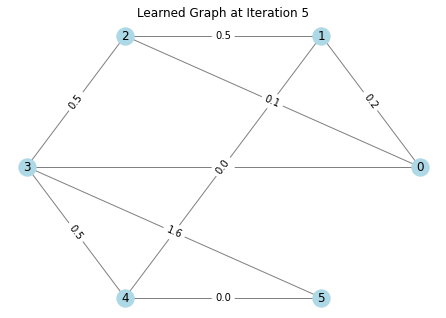

Final learned adjacency matrix:
tensor([[0.0000, 0.1807, 0.0886, 0.0961, 0.0000, -0.0000],
        [0.1807, 0.0000, 0.4709, -0.0000, 0.0372, 0.0000],
        [0.0886, 0.4709, 0.0000, 0.4975, 0.0000, 0.0000],
        [0.0961, -0.0000, 0.4975, 0.0000, 0.5117, 1.5913],
        [0.0000, 0.0372, 0.0000, 0.5117, 0.0000, 0.0492],
        [-0.0000, 0.0000, 0.0000, 1.5913, 0.0492, 0.0000]],
       grad_fn=<MulBackward0>) tensor(6.6335, grad_fn=<PowBackward0>)


In [4]:
# torch.manual_seed(42)
gem = GEM(num_nodes, mu=0.01, gamma=0.4, step_size=0.01, c=5, scale=True)
# initialize adjacency and S
# adj_init = torch.ones((num_nodes, num_nodes)) - torch.eye(num_nodes)  # all-one matrix with zero diagonal
S_init = torch.ones((num_nodes, num_nodes)) - torch.eye(num_nodes)  # all-one matrix with zero diagonal
# run GEM
# with torch.no_grad():
    # draw_graph_from_adj(adj_init, title='Initial Graph')
x_final, adj_final, S_final = gem(y, S_init, num_iters=5)
W_final = adj_final * S_final
print("Final learned adjacency matrix:")
print(W_final, W_final.norm()**2)

In [5]:
# class GraphLearningModule(nn.Module):
#     # generate weight matrix from node embeddings
#     def __init__(self, num_nodes, emb_dim=6, feature_dim=3, alpha=1.0, c=8):
#         super(GraphLearningModule, self).__init__()
#         self.num_nodes = num_nodes
#         # embedding vectors
#         self.node_embeddings = nn.Parameter(torch.randn(num_nodes, emb_dim))  # emb_dim-dimensional embeddings
#         self.fc = nn.Linear(emb_dim, feature_dim)
#         self.leakyrelu = nn.LeakyReLU(0.2)
#         # self.alpha = alpha # scaling factor by calculation
#         self.c = c

#     # def scale_alpha(self, adj):
#     #     # scale alpha such that norm(alpha * adj) = c
#     #     current_norm = torch.norm(self.alpha * adj)
#     #     print('current norm', current_norm)
#     #     scaling_factor = self.c / current_norm**2 if current_norm != 0 else 1
#     #     self.alpha *= scaling_factor
#     #     return scaling_factor

#     def forward(self, x):
#         # x: (batch_size, num_nodes)
#         B = x.size(0)
#         # embed each node
#         # Expand node_embeddings to batch dimension and add directly to x
#         e = x.unsqueeze(-1) + self.node_embeddings.unsqueeze(0) # in shape (B, N, emb_dim)
#         f = self.leakyrelu(self.fc(e)) # in shape (B, N, feature_dim)
#         df = f.unsqueeze(2) - f.unsqueeze(1) # in shape (B, N, N, feature_dim)
#         # dis = torch.norm(df, dim=-1)
#         adj = torch.exp(-(df**2).sum(-1)).mean(0) # in shape (N, N)
#         adj.fill_diagonal_(0)
#         # print('adj before scaling', adj, adj.norm()**2, self.alpha)
#         # scaling_factor = self.scale_alpha(adj)
#         # print('scale', scaling_factor)
#         # adj = adj * scaling_factor
#         # print(self.alpha)
#         return adj
    
